In [1]:
import os,shutil
import json
from glob import glob
from pathlib import Path
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA, ConversationalRetrievalChain,LLMChain
from langchain.llms import HuggingFaceHub
from langchain.prompts import PromptTemplate
import pandas as pd
from langchain.llms import HuggingFacePipeline, HuggingFaceHub
from huggingface_hub import login
import warnings
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

In [2]:
secret_key_path = './secret_key.txt'
with open(secret_key_path, 'r') as file:
    secret_key = file.read().strip()

login(token=secret_key)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\HP\.cache\huggingface\token
Login successful


In [3]:
with open('./faqs.json', 'r') as file:
    faq_data = json.load(file)

documents = []
for category, items in faq_data.items():
    for entry in items:
        documents.append({
            'category': category,
            'question': entry['question'],
            'answer': entry['answer']
        })

In [4]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Below lines are for generating embeddings for the questions
questions = [doc['question'] for doc in documents]
question_embeddings = model.encode(questions)

# Indexing using FAISS
dimension = question_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(question_embeddings))

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
def semantic_search(query, top_k=3):
    query_embedding = model.encode([query])
    distances, indices = index.search(np.array(query_embedding), top_k)
    results = [documents[i] for i in indices[0]]
    return results

# Example query
query = "What are the payment options for tuition fees?"
relevant_docs = semantic_search(query)

print(relevant_docs)

[{'category': 'Tuition fee and Scholarships', 'question': 'Are there any payment plans or options available for tuition fees? ', 'answer': 'Yes, we offer flexible payment plans to help students manage their tuition fees. At Saras AI Institute, you can pay your annual tuition fees in 5 installments, before the commencement of every semester.'}, {'category': 'Tuition fee and Scholarships', 'question': ' What are the tuition fees for your courses?', 'answer': "You can find detailed information and breakdown of the fee on 'Programs' page on the website"}, {'category': 'Tuition fee and Scholarships', 'question': 'Can I avail financial aid? ', 'answer': "You currently can't get a federal aid for Saras AI Institute's programs. However, we are partnering with lenders who can help facilitate a loan to help pay the tuition."}]


In [8]:
faiss.write_index(index, './faiss_index.index')

with open('./documents.pkl', 'wb') as f:
    pickle.dump(documents, f)

In [9]:
llm = HuggingFaceHub(
    repo_id="mistralai/Mistral-7B-Instruct-v0.3",
    model_kwargs={"temperature": 0.2,"max_new_tokens":512, "return_full_text":False},
    huggingfacehub_api_token=secret_key
)

prompt_template = PromptTemplate(
    template="You are an AI assistant helping to answer user queries. Use the following context to provide an answer.\n\nContext:\n{context}\n\nQuery:\n{query}\nAnswer:",
    input_variables=["context", "query"]
)

In [10]:
def get_relevant_context(query, top_k=3):
    # Performing semantic search
    query_embedding = model.encode([query])
    distances, indices = index.search(np.array(query_embedding), top_k)
    results = [documents[i] for i in indices[0]]

    # Combining the retrieved answers for the LLM prompt
    context = " ".join([doc['answer'] for doc in results])
    return context

def generate_answer_with_llm(query):
    context = get_relevant_context(query)
    
    formatted_prompt = prompt_template.format(context=context, query=query)
    
    response = llm(formatted_prompt)
    
    return response

# Testing
user_query = "What are the payment options for tuition fees?"
answer = generate_answer_with_llm(user_query)
print("Generated Response:", answer)


Generated Response: 
At Saras AI Institute, you can pay your annual tuition fees in 5 installments, before the commencement of every semester. You can find detailed information and breakdown of the fee on the 'Programs' page on the website. Additionally, we are partnering with lenders who can help facilitate a loan to help pay the tuition.


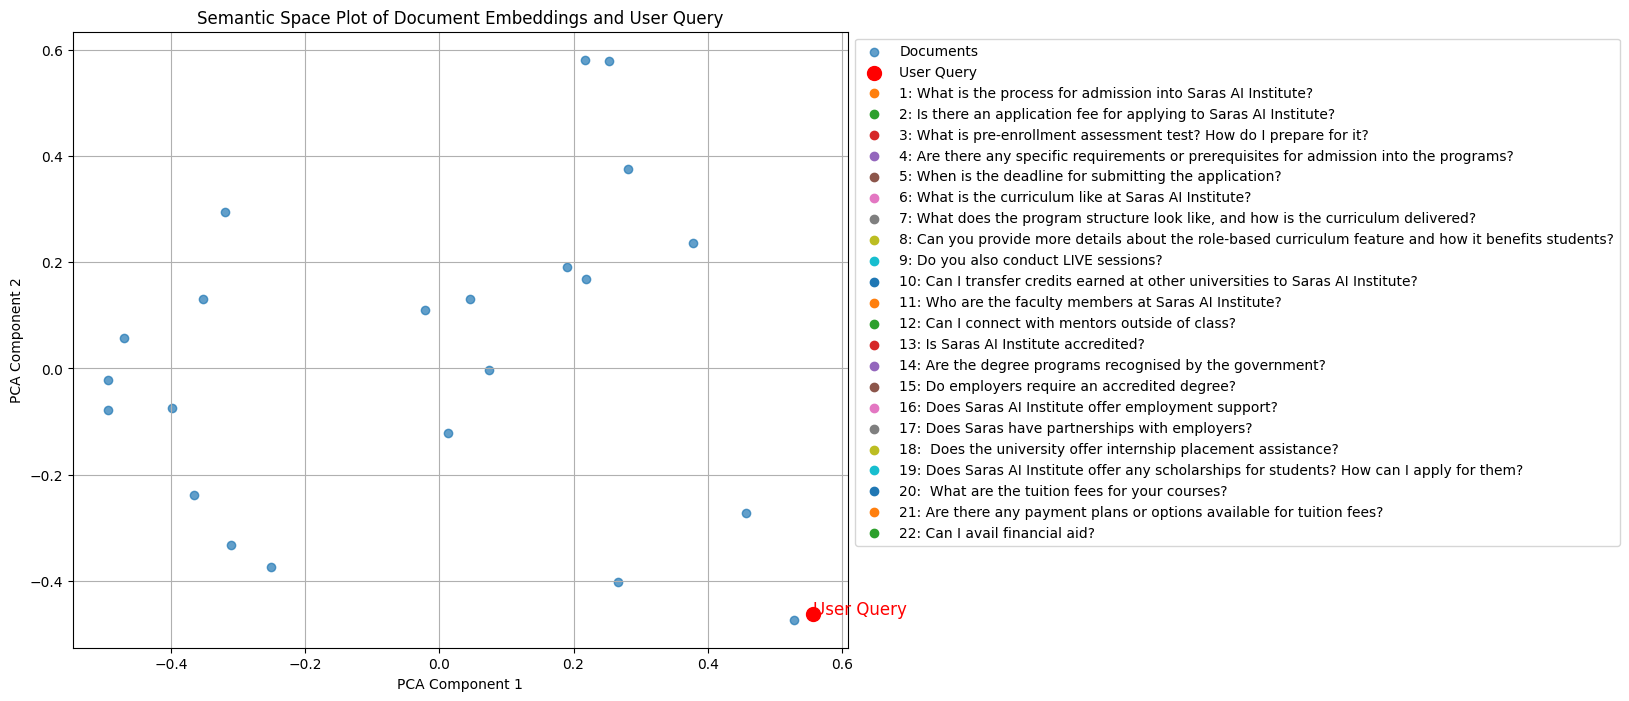

In [13]:
# Loading created FAISS index
index = faiss.read_index('./faiss_index.index')

with open('./documents.pkl', 'rb') as f:
    documents = pickle.load(f)

model = SentenceTransformer('all-MiniLM-L6-v2')

# Get embeddings from the FAISS index
question_embeddings = index.reconstruct_n(0, index.ntotal)

user_query = "What are the payment options for tuition fees?"
query_embedding = model.encode([user_query])

all_embeddings = np.vstack((question_embeddings, query_embedding))

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:-1, 0], reduced_embeddings[:-1, 1], label='Documents', alpha=0.7)
plt.scatter(reduced_embeddings[-1, 0], reduced_embeddings[-1, 1], color='red', label='User Query', s=100)

for i, doc in enumerate(documents):
    question = doc['question']
    plt.scatter([], [], label=f"{i + 1}: {question}")  # Create invisible points for legend

plt.annotate("User Query", (reduced_embeddings[-1, 0], reduced_embeddings[-1, 1]), fontsize=12, color='red')

plt.title('Semantic Space Plot of Document Embeddings and User Query')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the plot
plt.grid()
plt.show()


In [15]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def get_suggestions(user_input, top_k=5):
    # Encode the user's input
    input_embedding = model.encode([user_input])

    # Search for the closest questions in the FAISS index
    distances, indices = index.search(np.array(input_embedding), top_k)
    
    # Retrieve relevant documents based on indices
    suggested_questions = [documents[i]['question'] for i in indices[0]]
    
    return suggested_questions

# Example usage
user_input = "What are the payment options for tuition"
suggested_questions = get_suggestions(user_input)

print("Suggested Questions:")
for i, question in enumerate(suggested_questions, 1):
    print(f"{i}: {question}")

Suggested Questions:
1: Are there any payment plans or options available for tuition fees? 
2:  What are the tuition fees for your courses?
3: Can I avail financial aid? 
4: Does Saras AI Institute offer any scholarships for students? How can I apply for them? 
5:  Does the university offer internship placement assistance?
